In [1]:
import numpy as np
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchtext.data
import random
import matplotlib.pyplot as matpy
import math

torch.cuda.manual_seed(1)


In [2]:
dict_Vectors = {}

with open("/home/achingacham/Model/GRID_data/Evaluation_Datasets/BLESS/preTrainedVectors.txt") as inputFile:
    Vectors = inputFile.readlines()
    
    for vec in Vectors:
        data = vec.split()
        if data[0] not in dict_Vectors.keys():
            dict_Vectors[data[0]] = data[1:]


In [3]:
class RelationClassifier(nn.Module):
    # Module which implements the model
    def __init__ (self,input_dim, hidden_dim, output_dim):
        nn.Module.__init__(self)
        
        self.linear_input = nn.Linear(input_dim,hidden_dim)
        self.linear_hidden = nn.Linear(hidden_dim,output_dim)
        
    def forward(self, batch_input_vector):
        
        #print("Ïnside....forward")
        batch_size = len(batch_input_vector)      
        batch_op = np.zeros((batch_size,8))
        batch_output = autograd.Variable(torch.cuda.FloatTensor(batch_op), requires_grad=True)
        

        #for index,input_vector in enumerate(batch_input_vector):
        
        hidden_layer = self.linear_input(batch_input_vector)
        hidden_units = F.tanh(hidden_layer)
        batch_output = self.linear_hidden(hidden_units)
        
        #batch_output[index] = output
            
        
        return(F.log_softmax(batch_output))
    

In [4]:
#Make input vectors

def make_input_vector(target,relata):
    
    word1 = target.lower()
    word2 = relata.lower()
    
    #collect the respective vectors for word 1 & 2
    vector_1 = np.array(dict_Vectors[word1])
    vector_1 = np.ndarray.astype(vector_1,float)
    vector_2 = np.array(dict_Vectors[word2])
    vector_2 = np.ndarray.astype(vector_2,float)
    
    #Combine these two vectors to form a single vector
    
    relation_vector = vector_1 - vector_2    
    tensor = torch.cuda.FloatTensor(relation_vector)
    
   
    return(tensor)


In [5]:
def make_batch_input_vector(batch_target,batch_relata):
    
    batch_relation_vector = []
    
    for target,relata in zip(batch_target,batch_relata):
    
        word1 = target.lower()
        word2 = relata.lower()
    
        #collect the respective vectors for word 1 & 2
        
        vector_1 = np.array(dict_Vectors[word1])
        vector_1 = np.ndarray.astype(vector_1,float)
        vector_2 = np.array(dict_Vectors[word2])
        vector_2 = np.ndarray.astype(vector_2,float)
    
        #Combine these two vectors to form a single vector
    
        relation_vector = vector_1 - vector_2    
        
        batch_relation_vector.append(relation_vector)
    
    return(torch.cuda.FloatTensor(batch_relation_vector))

def make_batch_target_vector(batch_relation):
    
    batch_relation_indices = []
    
    for relation in batch_relation:
        batch_relation_indices.append(labels_to_ix[relation])
        #print(torch.cuda.LongTensor(batch_relation_indices))
    return(torch.cuda.LongTensor(batch_relation_indices))


In [6]:
#MODEL

INPUT_DIM = 400
HIDDEN_UNIT = 400
OUTPUT_LABEL = 8


model = RelationClassifier(INPUT_DIM, HIDDEN_UNIT, OUTPUT_LABEL)
loss = nn.NLLLoss()
optimizer = torch.optim.SGD(model.parameters(),lr=0.03)



In [7]:
if torch.cuda.is_available():
    model.cuda()
    pass


In [8]:
#TRAINING

labels_to_ix = {}
bs = 32
epoch_cost = []

for epoch in range(10):

    
    #SPlit dataset to avoid lexical memorization
    print("Epoch :", epoch)
    with open("/home/achingacham/Model/GRID_data/Evaluation_Datasets/BLESS/UniqueTuples") as inputFile:
        content = inputFile.readlines()
        total_data = len(content) 
        #60% train, 10% dev, 30% test
        random.shuffle(content)
        train_data  = content[0:int(total_data*.6)]
        dev_data    = content[int(total_data*.6):int(total_data*.7)]
        test_data   = content[int(total_data*.7):]


    N = math.ceil(len(train_data)/bs)

    Train_Error_cost = []
    Average_cost = 0

    for i in range(N):

        batch_entry = train_data[i*bs:i*bs+bs]

        batch_concept = []
        batch_relata = []
        batch_relation = []

        for index,split_data in enumerate(batch_entry):
            batch_concept.append(split_data.split()[0])
            batch_relata.append(split_data.split()[1])
            batch_relation.append(split_data.split()[2])

            if split_data.split()[2] not in labels_to_ix:
                labels_to_ix[split_data.split()[2]] = len(labels_to_ix)


        batch_input_vector = autograd.Variable(make_batch_input_vector(batch_concept,batch_relata), requires_grad = True)
        batch_target_label = autograd.Variable(make_batch_target_vector(batch_relation))
        
        model.zero_grad() 
        
        batch_log_prob = model(batch_input_vector)
         
        batch_cost = loss(batch_log_prob,batch_target_label)
        
        batch_cost.backward()
        
        optimizer.step()

        Train_Error_cost.append(batch_cost.data.tolist())
      
        Average_cost += batch_cost.data.tolist().pop()
    
    print("Average cost", Average_cost/len(train_data))
    
    epoch_cost.append(Average_cost/len(train_data))

Epoch : 0


/home/achingacham/.local/lib/python3.5/site-packages/ipykernel_launcher.py:26: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Average cost 0.05455293673778284
Epoch : 1
Average cost 0.03711660087376066
Epoch : 2
Average cost 0.029145313305249974
Epoch : 3
Average cost 0.02564545481566464
Epoch : 4
Average cost 0.023925551563239555
Epoch : 5
Average cost 0.022595430261633877
Epoch : 6
Average cost 0.021907974523546602
Epoch : 7
Average cost 0.02129605801798771
Epoch : 8
Average cost 0.020891780887513173
Epoch : 9
Average cost 0.02069040586999927


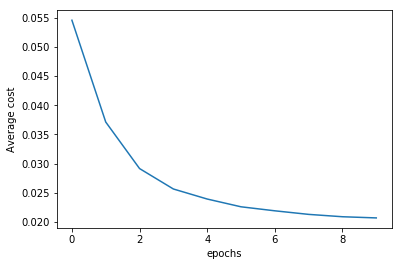

In [9]:
    
matpy.plot(epoch_cost)
matpy.ylabel("Average cost")
matpy.xlabel("epochs")
matpy.show()

In [10]:
count = 0
Dev_Error_cost = []

for entry in dev_data:
    input_words = entry.split()
    
    concept = input_words[0]
    relata = input_words[1]   
    relation = input_words[2]
    
    input_vector = autograd.Variable(make_input_vector(concept,relata))
    target_label = autograd.Variable(torch.cuda.LongTensor([labels_to_ix[relation]]))
    
    log_prob = model(input_vector)
    
    predict_label = log_prob.max(0)[1]
    
    #print(log_prob, predict_label)
    
    #dev_cost = loss(log_prob,target_label)

    #Dev_Error_cost.append(dev_cost.data.tolist())

    if(str(predict_label.data) == str(target_label.data)):     
        count += 1
        
# In[79]:

#print("Error for Dev set", Dev_Error_cost)

print("Accuracy",(count/len(dev_data))*100)


/home/achingacham/.local/lib/python3.5/site-packages/ipykernel_launcher.py:26: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Accuracy 78.50644427596663
